In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Load dataset

df = pd.read_csv("stores_sales_forecasting.csv", encoding='latin1')

df.head(5)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
3,6,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.8600,7,0.00,14.1694
4,11,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-TA-10001539,Furniture,Tables,Chromcraft Rectangular Conference Tables,1706.1840,9,0.20,85.3092


In [ ]:
# Prepared dataset for prophet

# Convert Order Date to datetime
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%m/%d/%Y')

# Aggregate total sales by quarter
df_quarterly = df.groupby(pd.Grouper(key='Order Date', freq='Q')).agg({'Sales': 'sum'}).reset_index()

# Rename columns for Prophet
df_quarterly.rename(columns={'Order Date': 'ds', 'Sales': 'y'}, inplace=True)

print(df_quarterly.head())

          ds           y
0 2014-03-31  22656.1390
1 2014-06-30  28063.7496
2 2014-09-30  41957.8783
3 2014-12-31  64515.0862
4 2015-03-31  27374.0986


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_1292\707429141.py:7: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df_quarterly = df.groupby(pd.Grouper(key='Order Date', freq='Q')).agg({'Sales': 'sum'}).reset_index()


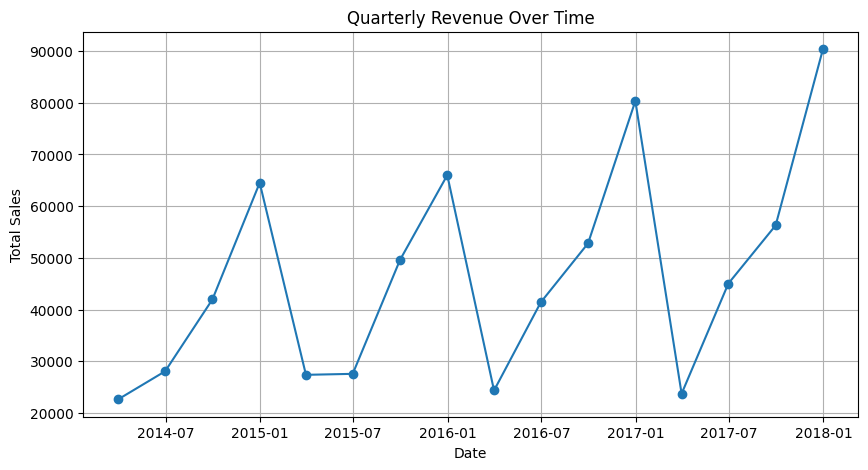

In [ ]:
# Visulize quarterly revenue

plt.figure(figsize=(10,5))
plt.plot(df_quarterly['ds'], df_quarterly['y'], marker='o')
plt.title('Quarterly Revenue Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

In [9]:
# Split dataset into train and test set

split_index = int(len(df_quarterly) * 0.8)
train = df_quarterly.iloc[:split_index]
test = df_quarterly.iloc[split_index:]

In [10]:
# Fit prophet model on train dataset

model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model.fit(train)

16:57:57 - cmdstanpy - INFO - Chain [1] start processing
16:58:03 - cmdstanpy - INFO - Chain [1] done processing


c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  dates = pd.date_range(


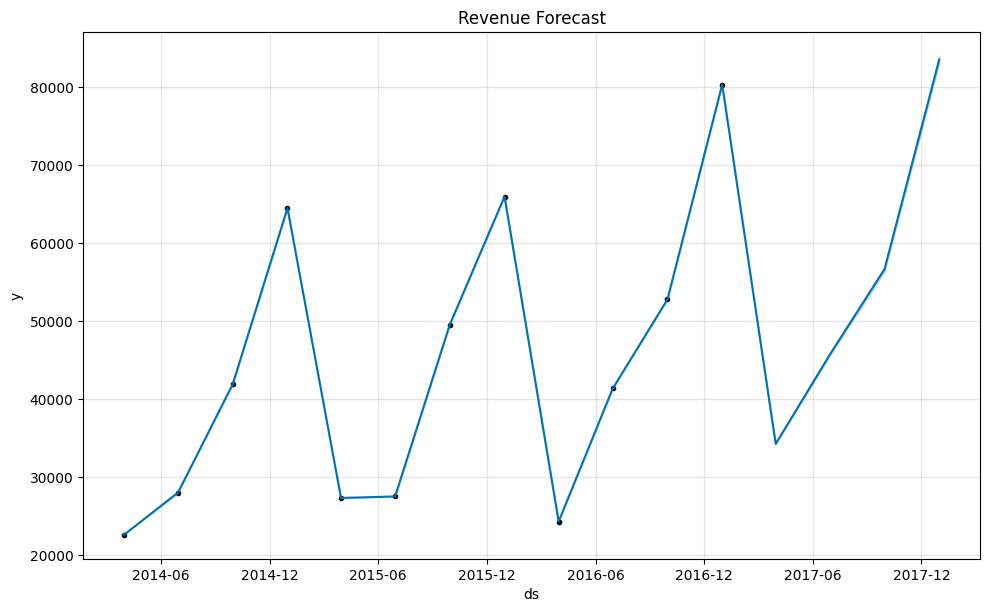

In [11]:
# Forecat future revenue

future = model.make_future_dataframe(periods=len(test), freq='Q')
forecast = model.predict(future)

# Plot forecast
model.plot(forecast)
plt.title('Revenue Forecast')
plt.show()

In [12]:
# Evaluate forcast accuracy

# Extract predictions for test period
forecast_test = forecast.set_index('ds').loc[test['ds']]
y_true = test['y'].values
y_pred = forecast_test['yhat'].values

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')

Mean Absolute Error (MAE): 4620.33
Root Mean Squared Error (RMSE): 6298.06


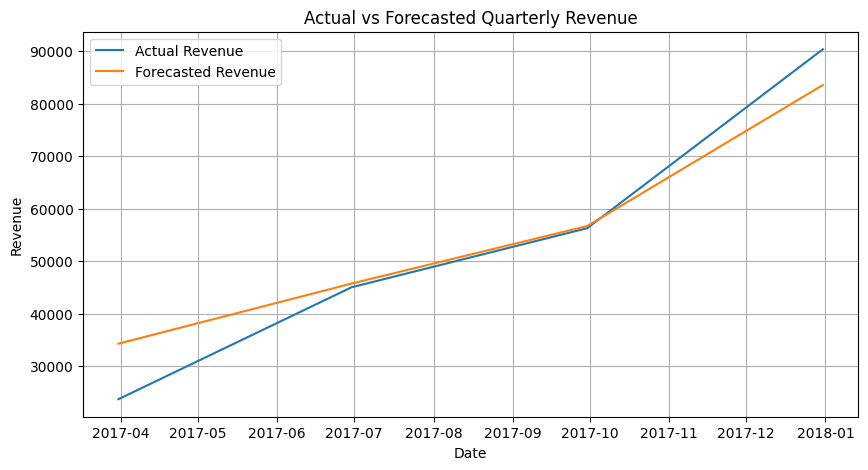

In [13]:
# Plot actual vs forcast

plt.figure(figsize=(10,5))
plt.plot(test['ds'], y_true, label='Actual Revenue')
plt.plot(test['ds'], y_pred, label='Forecasted Revenue')
plt.title('Actual vs Forecasted Quarterly Revenue')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
# Save forcast to csv

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv('quarterly_revenue_forecast.csv', index=False)